In [1]:
from comet_ml import Experiment
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,classification_report, PrecisionRecallDisplay, brier_score_loss
from sklearn.metrics import roc_curve, auc
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import os 
import pickle
import seaborn as sn
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from comet_api_key import comet_ml_key
import warnings
warnings.filterwarnings("ignore")

In [2]:
experiment = Experiment(
    api_key=comet_ml_key(),
    project_name="nhl-analytics",
    workspace="ift6758-22-team2",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-22-team2/nhl-analytics/ca369bf926c34d959337975ef7fd027e



##### Read Complete NHL DATA

In [3]:
df=pd.read_csv('./tidy_data/complete_dataset.csv',index_col=0)

#### Splitting Train Data

In [4]:
train=df[(df['season'] != '20192020') & (df['gameType'] == 'R')]

In [5]:
train_x=train[['change_in_shot_angle','shot_angle_absolute','distanceNet_or_shotDistance','nbOpposing_non_goalie_skaters',
'nbFriendly_non_goalie_skaters','time_since_powerplay_started','speed','rebound','distance_from_last_event','x','y','last_x','last_y'
]]
train_y=train['goal']

In [6]:
train_x['rebound'] = train_x['rebound']*1
train_x

,change_in_shot_angle,shot_angle_absolute,distanceNet_or_shotDistance,nbOpposing_non_goalie_skaters,nbFriendly_non_goalie_skaters,time_since_powerplay_started,speed,rebound,distance_from_last_event,x,y,last_x,last_y
5475,0.000000,10.007980,34.525353,5,5,0,14.025066,0,154.275727,-55.0,6.0,94.0,-34.0
5476,0.000000,0.000000,10.000000,5,5,0,7.211103,0,50.477718,-79.0,0.0,-37.0,-28.0
5477,4.085617,4.085617,14.035669,5,5,0,4.123106,1,4.123106,-75.0,-1.0,-79.0,0.0
5478,0.000000,46.636577,49.517674,5,5,0,4.422515,0,79.605276,-55.0,-36.0,-91.0,35.0
5479,0.000000,2.045408,28.017851,5,5,0,4.494441,0,22.472205,-61.0,-1.0,-69.0,-22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409357,164.872821,12.264774,23.537205,5,5,0,3.652250,1,135.133268,66.0,5.0,-69.0,-1.0
409358,0.000000,6.009006,19.104973,5,5,0,NaN,0,NaN,70.0,2.0,NaN,NaN
409359,0.000000,2.385944,24.020824,5,5,0,NaN,0,129.015503,65.0,1.0,-64.0,3.0
409360,0.000000,7.125016,24.186773,5,5,0,NaN,0,130.015384,-65.0,3.0,65.0,1.0


#### Splitting Complete Train dataset into train and validation set


In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_x.fillna(0),train_y, test_size=0.25,random_state=10, shuffle = True, stratify=train_y.to_numpy())

{'web': 'https://www.comet.com/api/image/download?imageId=804ae0dc78d84edcb48bfc732c1643c2&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=804ae0dc78d84edcb48bfc732c1643c2&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'imageId': '804ae0dc78d84edcb48bfc732c1643c2'}

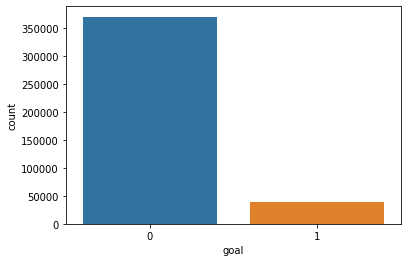

In [8]:
sn.countplot(x ='goal', data = df)
experiment.log_figure(figure_name='Class Label Count Plot', step=None)

Load Saved Models

In [9]:
mlp = pickle.load(open('./models/MLP_classifier.sav','rb'))
Rf=pickle.load(open('./models/Random_forest.sav','rb'))
Knn=pickle.load(open('./models/Knn.sav','rb'))

In [10]:
classifier_pipeline=[mlp,Rf,Knn]

In [11]:
mlp

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB53D5FB80>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   Ordin...(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB522F4400>)])),
                ('feature_select',
                 SelectFromModel(estimator=LinearSVC(C=0.1, dual=False,
                                                     penalty='l1'))),
                ('classifier',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               hidden_layer_sizes=(10, 100, 10),
                               learning_rate='adaptive'))])

In [12]:
Rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB53DDB400>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   Ordin...ategories‘auto',
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB53DDB490>)])),
                ('feature_select',
                 RFECV(estimator=LinearRegression(), verbose=3)),
                ('classifier',
                 RandomForestClassifier(max_depth=60, max_features='auto',
                                        min_samples_split=5, n_estimators=20,
                                        random_state=0))])

In [13]:
Knn

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB53DDB8B0>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB57158A00>)])),
                ('feature_select',
                 RFE(estimator=DecisionTreeClassifier(), verbose=3)),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

Test to find best Model

In [14]:
best_accuracy=[]
best_classifier=0
best_pipeline=""
pipe_dict={0:'Mlp Classifier',1:'RandomForest Classifier',2:'Knn Classifier'}

In [15]:
for pipe in classifier_pipeline:
    pipe.fit(X_train,y_train)

COMET WARNING: truncated string; too long: 'ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB53DDB400>),
                                ('Categorical_transform',
                                 Pipeline(steps=[('Impt',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories='categories‘auto',
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 <sklearn.compose._column_transforme

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

COMET WARNING: truncated string; too long: 'ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB53DDB400>),
                                ('Categorical_transform',
                                 Pipeline(steps=[('Impt',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories='categories‘auto',
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 <sklearn.compose._column_transforme

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.


In [16]:
for i,model in enumerate(classifier_pipeline):
    print("{} Test Accuracy : {}".format(pipe_dict[i],model.score(X_val,y_val)))

Mlp Classifier Test Accuracy : 0.9080047538414615
RandomForest Classifier Test Accuracy : 0.9072054353656356
Knn Classifier Test Accuracy : 0.8841303730503466


In [17]:
best_model=[]
for i,model in enumerate(classifier_pipeline):
    best_model.append(model.score(X_val,y_val))
best_classifier=best_model.index(max(best_model))
print('Classifier with best Accuracy : {}.'.format(pipe_dict[best_classifier]))        

Classifier with best Accuracy : Mlp Classifier.


##### Model performance Visualization

{'web': 'https://www.comet.com/api/image/download?imageId=8de0c56c46e543f580ce89adfcd80417&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=8de0c56c46e543f580ce89adfcd80417&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'imageId': '8de0c56c46e543f580ce89adfcd80417'}

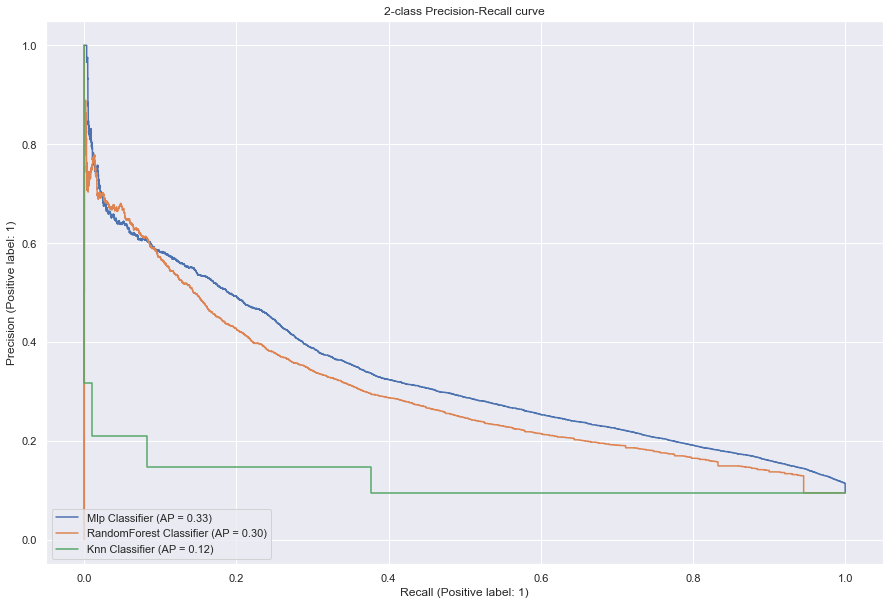

In [18]:
fig = plt.figure(figsize=(15, 10))
sn.set()
for i,model in enumerate(classifier_pipeline):
    display= PrecisionRecallDisplay.from_estimator(model,X_val, y_val, ax = plt.gca(),name = pipe_dict[i])   
display.ax_.set_title("2-class Precision-Recall curve")
experiment.log_figure(figure_name='Precision-Recall Curve', step=None)

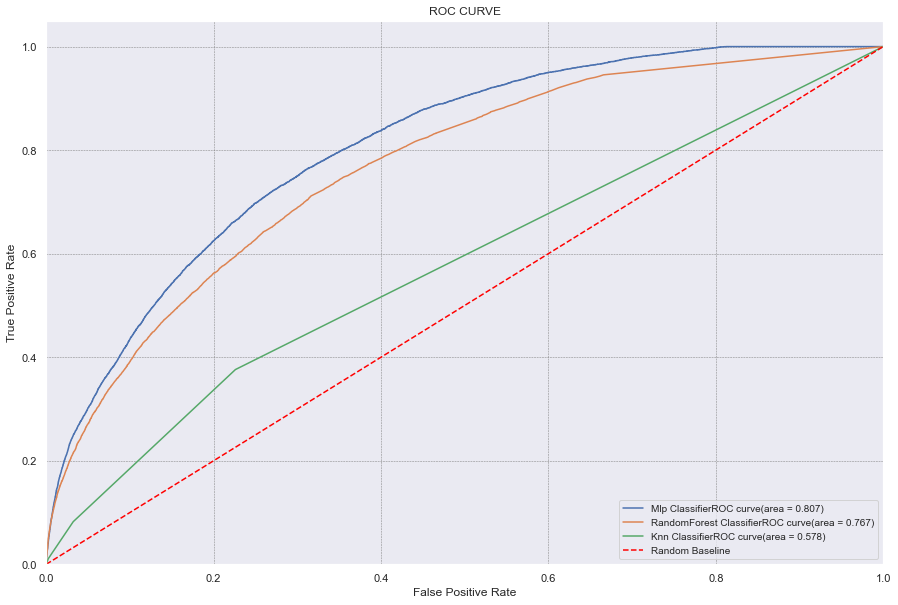

In [19]:
fig = plt.figure(figsize=(15, 10))
for i,model in enumerate(classifier_pipeline):

# Get FPR, TPR and AUC
    predictions=model.predict_proba(X_val)
    fpr, tpr, _ = roc_curve(y_val,predictions[:,1].ravel())
    roc_auc = auc(fpr, tpr)
    sn.set()
    plt.plot(fpr, tpr, label=str(pipe_dict[i])+"ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right", fontsize='small')    
experiment.log_figure(figure_name='ROC Curve', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=992449d3b0dd48aa8bdc89d8d1161fb3&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=992449d3b0dd48aa8bdc89d8d1161fb3&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'imageId': '992449d3b0dd48aa8bdc89d8d1161fb3'}

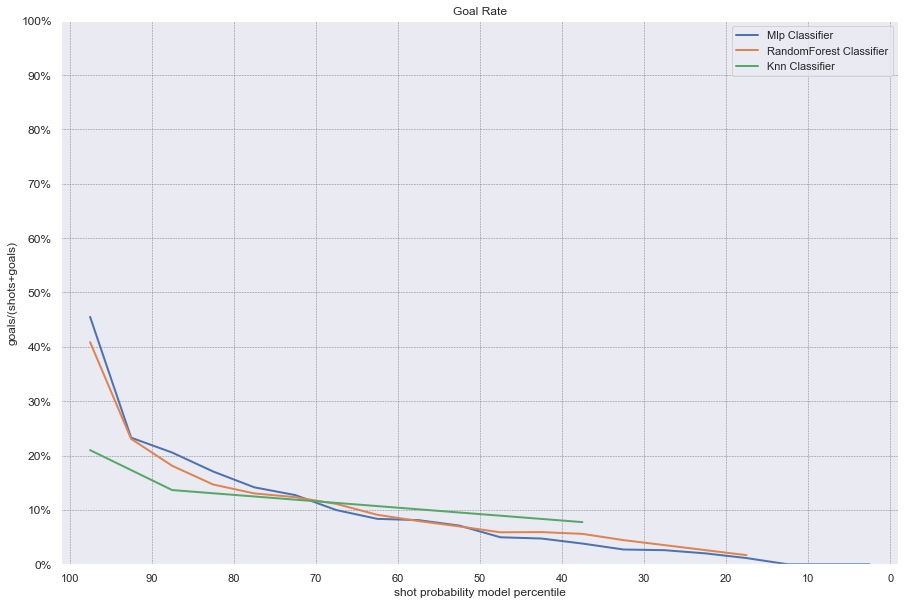

In [20]:
fig = plt.figure(figsize = (15,10))
for i,model in enumerate(classifier_pipeline):
    predictions=model.predict_proba(X_val)
    y_pred_val = model.predict(X_val) 
    bins = list(np.arange(0, 105,  5))
    bin_centers = list(np.arange(2.5, 100,  5.0))
    df_prob = pd.DataFrame(list(zip(y_pred_val ,y_val,predictions[:,1]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()
    df_prob['percentile'] = df_prob['goal_Prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
    df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
    df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
    df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
    df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()
    ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_rate', data = df_prob_bined, linewidth = 2,label=str(pipe_dict[i]))
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('goals/(shots+goals)')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.yticks(np.arange(0,1.1,.1))
    yvals = ax.get_yticks()
    ax.set_yticklabels(["{:,.0%}".format(y) for y in yvals], fontsize=12)
    plt.xticks(np.arange(0,110,10))
plt.title(f"Goal Rate")    
experiment.log_figure(figure_name='Goal Rate', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=d1efbc387b4f4143a4d93d138fcdc8bb&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=d1efbc387b4f4143a4d93d138fcdc8bb&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'imageId': 'd1efbc387b4f4143a4d93d138fcdc8bb'}

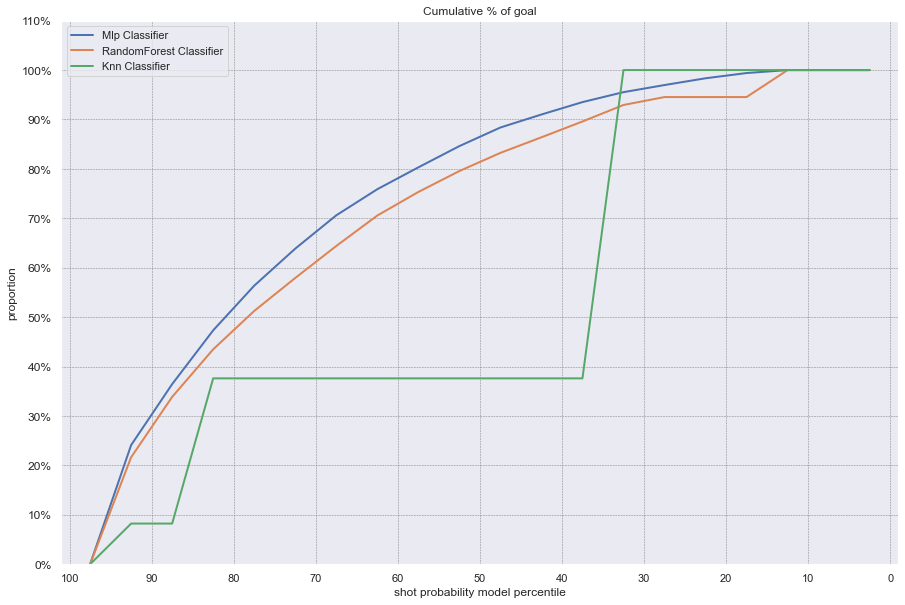

In [21]:

fig = plt.figure(figsize = (15,10))
for i,model in enumerate(classifier_pipeline):
    predictions=model.predict_proba(X_val)
    y_pred_val = model.predict(X_val) 
    bins = list(np.arange(0, 105,  5))
    bin_centers = list(np.arange(2.5, 100,  5.0))
    df_prob = pd.DataFrame(list(zip(y_pred_val ,y_val,predictions[:,1]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()
    df_prob['percentile'] = df_prob['goal_Prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
    df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
    df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
    df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
    df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()
    plt.title(f"Cumulative % of goal")
    ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_cumsum', data = df_prob_bined, label=str(pipe_dict[i]), linewidth = 2)
    plt.grid(color='gray', linestyle='--', linewidth=.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.yticks(np.arange(0,1.2,.1))
    yvals = ax.get_yticks()
    ax.set_yticklabels(["{:,.0%}".format(y) for y in yvals], fontsize=12)
    plt.xticks(np.arange(0,110,10))

experiment.log_figure(figure_name=f'Cumulative % of goals', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=3ce38af970094181bef69d3cc9763b91&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=3ce38af970094181bef69d3cc9763b91&experimentKey=ca369bf926c34d959337975ef7fd027e',
 'imageId': '3ce38af970094181bef69d3cc9763b91'}

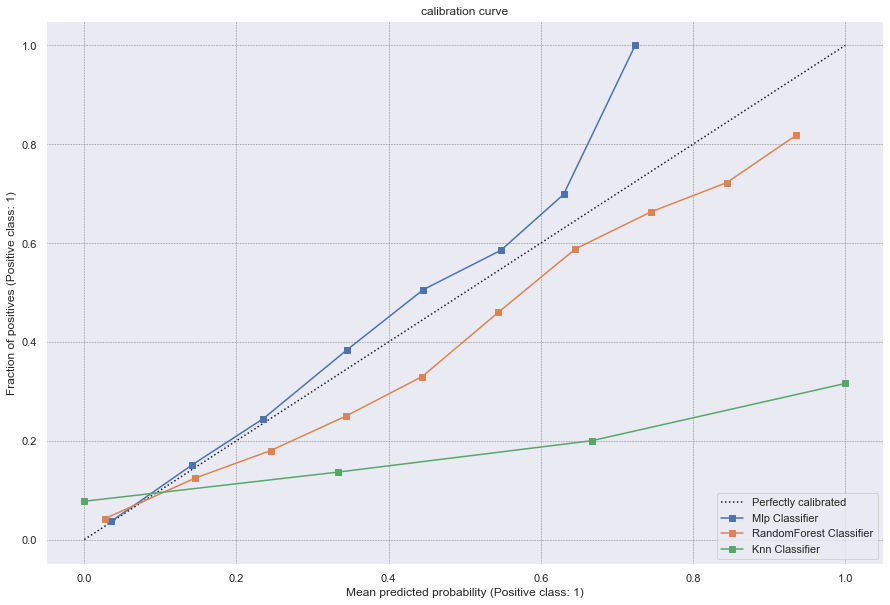

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
for i,model in enumerate(classifier_pipeline):
    predictions=model.predict_proba(X_val)
    y_pred_val = model.predict(X_val)
    disp = CalibrationDisplay.from_predictions(y_val, predictions[:,1].ravel(), n_bins=10, ax = plt.gca(),name = pipe_dict[i])
    plt.grid(color='gray', linestyle='--', linewidth=.5)
    plt.title(f"calibration curve")
experiment.log_figure(figure_name='Calibration plots', step=None)

In [23]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-22-team2/nhl-analytics/ca369bf926c34d959337975ef7fd027e
COMET INFO:   Parameters:
COMET INFO:     C                                                                   : 0.1
COMET INFO:     activation                                                          : tanh
COMET INFO:     add_indicator                                                       : False
COMET INFO:     algorithm                                                           : auto
COMET INFO:     alpha                                                               : 0.001
COMET INFO:     batch_size                                                          : auto
COMET INFO:     beta_1                                                              : 0.9
COMET INFO:     beta_2       